### Exercício: Treinando um modelo de regressão linear para se comportar como um filtro FIR.

Um filtro FIR (do inglês, Finite Impulse Response) de ordem $M$, tem a seguinte estrutura

<img src="../figures/fir_filter.png" width="500px">

Essa estrutura pode ser representada matematicamente através da seguinte equação

$$y[n] = a_0 x[n] + a_1 x[n-1] + a_2 x[n-2] + \cdots + a_M x[n-M] = \sum_{k=0}^{M}{a_k x[n-k]},$$

onde $M$ é a ordem do filtro, $x$ é o sinal de entrada do filtro, $y$ é a saída do filtro, ou seja, o sinal filtrado e $a_k, \; \forall k$ são os coeficientes do filtro.

Perceba que esta é uma equação linear, onde temos uma combinação linear dos atributos, neste caso versões atrasadas do sinal de entrada $x[n]$, em relação aos pesos, que são os coeficientes do filtro.

Se a ordem do filtro, ou seja, o parâmetro $M$, já estiver definido previamente, só é necessário encontrar seus coeficientes.

Assim, podemos aplicar algoritmos de regressão linear para encontrar esses coeficientes.

Agora, vamos supor que temos um filtro operando em um sistema de telecomunicações e que queremos replicar este filtro para uso em outro sistema. Porém, nós não conhecemos o projeto do filtro. Ou seja, seu tipo (e.g., passa-baixas, passa-altas, etc.), sua ordem, frequência de corte, etc. 

Como podemos projetar um filtro que se aproxime das características do filtro desejado?

Uma possível abordagem é injetar ruído branco Gaussiano (i.e., média igual a zero e variância unitária) em sua entrada e usar as entradas e a saídas resultantes para treinar um modelo de regressão linear. Portanto, faça o seguinte:

+ Gere 1000 amostras retiradas de uma distribuição Gaussiana normal padrão.
+ Passe essas amostras através do filtro FIR dado no notebook de exemplo 
    + Estude o código presente no notebook de exemplo para entender como fazer isso.
    + A ordem do filtro FIR do notebook de exemplo é igual a 45.
+ Use uma função hipótese com o formato da equação que representa o filtro FIR (equação acima), note que temos um modelo linear.
    + A função `createDataset` cria uma matriz de atributos de entrada de acordo com a equação que representa o filtro FIR, ou seja, gera os atributos da função hipótese desejada. Portanto, use esta função para gerar a matriz que será usada durante o treinamento do modelo de regressão linear.
    + Cada linha da matriz de atributos retornada pela função `createDataset` corresponde a **um elemento** da array de saída do filtro FIR, ou seja, o valor esperado (rótulo) para a n-ésima linha da matriz de atributos corresponde ao n-ésimo elemento do vetor de saída do filtro.
    + Portanto, temos uma matriz de atributos com dimensões $N \times M+1$ e um vetor de rótulos (i.e., valores esperados) com dimensões $N \times 1$ que vem ser usados para o treinamento do modelo de regresão linear.
+ Use um objeto da classe `MLPRegressor` para treinar o modelo de regressão linear.
+ Após o treinamento do modelo de regressão linear, faça:
    + Calcule e imprima o valor do erro quadrático médio (use todo o conjunto de dados).
    + Imprima e compare os pesos do modelo com os coeficientes do filtro FIR. Eles são próximos?
    + Passe o sinal de teste (sinal com a soma de dois sinais cossenoidais gerados no notebook de exemplo) através do modelo de regressão linear (use a função `createDataset` para converter o sinal de teste em uma matriz e o método `predict` do modelo de regressão linear para filtrar o sinal de teste).
    + Plote a FFT do sinal de saída do modelo de regressão linear.
    + Compare a FFT do sinal de saída do modelo de regressão linear com a FFT do sinal de saída do filtro FIR. Os resultados são similares?

### Referências

[1] 'FIR filter', https://scipy-cookbook.readthedocs.io/items/FIRFilter.html

[2] 'Filters', https://pysdr.org/content/filters.html

### Importando módulos necessários.

In [1]:
import numpy as np
from scipy.signal import kaiserord, lfilter, firwin, freqz
import matplotlib.pyplot as plt

### Funções úteis.

In [2]:
def createDataset(x, M):
    '''Função que converte o vetor x (Nx1) de entrada em uma matriz NxM+1 seguindo a equação do filtro FIR.'''
    zeros = np.zeros((M,))
    x = np.r_[zeros, x]
    N = len(x)
    X = np.zeros((N-M, M+1))
    for i in range(N-M):
        s = -len(x)+M+i
        e = -len(x)-1+i
        X[i,:] = x[s:e:-1]
    return X

### Greando o sinal de entrada do filtro FIR.

**OBS**.: O sinal (vetor) de entrada do filtro FIR é a variável `x_fir`.

In [3]:
# Define number of samples.
N = 1000

# Time indexes.
n = np.arange(0,N)

# Sampling rate.
fs = 1000.0

# Cutoff frequency of the filter.
fc = 250.0

# Frequency index 0.
k0 = 100

# Frequency index 0.
k1 = 400

# Input signal.
x_fir = np.cos((2*np.pi*k0*n)/N) + np.cos((2*np.pi*k1*n)/N)

### Plotando o sinal de entrada do filtro FIR no domínio do tempo.

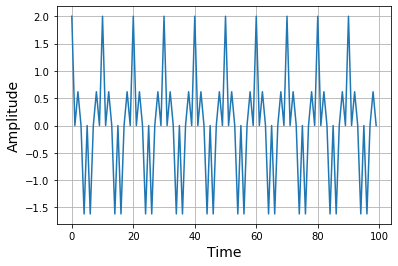

In [4]:
# Plot the first 100 samples.
plt.figure()
plt.plot(x_fir[0:100])
plt.xlabel('Time', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.grid()
plt.show()

### Plotando o sinal de entrada do filtro FIR no domínio da frequência.

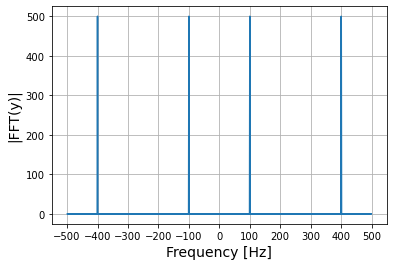

In [5]:
dft = np.fft.fft(x_fir)
freqs = np.fft.fftfreq(N, d=(1.0/(fs)))
dft = dft.reshape(N,)
dft = np.abs(dft)

plt.figure()
plt.plot(freqs, dft)
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('|FFT(y)|', fontsize=14)
plt.xticks(range(-500, 600, 100))
plt.grid()
plt.show()

### Criando os coeficientes do filtro FIR

In [6]:
# The Nyquist rate of the signal.
nyq_rate = fs/2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate. We'll design the filter
# with a 25 Hz transition width.
width = 50.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 40.0

# Compute the order and Kaiser parameter for the FIR filter.
order, beta = kaiserord(ripple_db, width)

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(order, fc/nyq_rate, window=('kaiser', beta))

print('FIR filter order:', order-1)
print('Number of taps of the FIR filter:', len(taps))
print('FIR taps:', taps)

FIR filter order: 45
Number of taps of the FIR filter: 46
FIR taps: [-0.00147957  0.00196122  0.00252175 -0.0031697  -0.00391484  0.00476859
  0.00574458 -0.00685949 -0.00813413  0.00959513  0.0112774  -0.01322788
 -0.01551144  0.01822048  0.02149142 -0.02553416 -0.03068898  0.03754528
  0.04721871 -0.06210339 -0.0884292   0.14904834  0.44965988  0.44965988
  0.14904834 -0.0884292  -0.06210339  0.04721871  0.03754528 -0.03068898
 -0.02553416  0.02149142  0.01822048 -0.01551144 -0.01322788  0.0112774
  0.00959513 -0.00813413 -0.00685949  0.00574458  0.00476859 -0.00391484
 -0.0031697   0.00252175  0.00196122 -0.00147957]


### Resposta em frequência do filtro FIR.

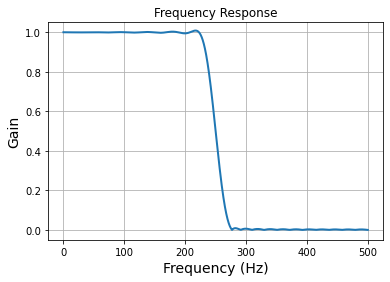

In [7]:
plt.figure()
w, h = freqz(taps, worN=8000)
plt.plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2)
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Gain', fontsize=14)
plt.title('Frequency Response')
plt.ylim(-0.05, 1.05)
plt.grid()
plt.show()

### Filtrando o sinal de entrada com o filtro FIR.

**OBS**.: O sinal (vetor) de saída do filtro é a variável `y_fir`.

In [8]:
# Use lfilter to filter y with the FIR filter.
y_fir = lfilter(taps, 1.0, x_fir)

### Plotando o sinal filtrado (saída do filtro FIR) no domínio do tempo.

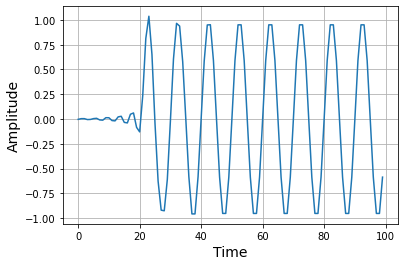

In [9]:
# Plot the first 100 samples.
plt.figure()
plt.plot(y_fir[0:100])
plt.xlabel('Time', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.grid()
plt.show()

### Plotando o sinal filtrado (saída do filtro FIR) no domínio da frequência.

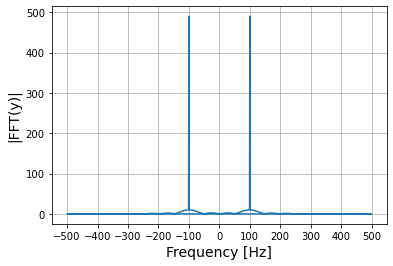

In [10]:
dft_fir = np.fft.fft(y_fir)
freqs = np.fft.fftfreq(N, d=(1.0/(fs)))
dft_fir = dft_fir.reshape(N,)
dft_fir_abs = np.abs(dft_fir)

plt.figure()
plt.plot(freqs, dft_fir_abs)
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('|FFT(y)|', fontsize=14)
plt.xticks(range(-500, 600, 100))
plt.grid()
plt.show()

### Número de amostras em ambos vetores.

In [11]:
print('Number of x samples:', x_fir.shape)
print('Number of y samples:', y_fir.shape)

Number of x samples: (1000,)
Number of y samples: (1000,)
